In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy

In [2]:
# Make transforms and use data loaders

# We'll use these a lot, so make them variables
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

chosen_transforms = {'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]),
}

In [3]:
# Set the directory for the data
data_dir = './chest_xray/'

# Use the image folder function to create datasets
chosen_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),chosen_transforms[x])
                   for x in ['train', 'val']}

In [4]:
# Make iterables with the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(chosen_datasets[x], batch_size=4,
  shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [5]:
dataset_sizes = {x: len(chosen_datasets[x]) for x in ['train', 'val']}
class_names = chosen_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Visualize some images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

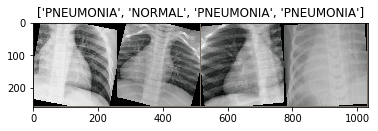

In [7]:
# Grab some of the training data to visualize
inputs, classes = next(iter(dataloaders['train']))

# Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [12]:
import torch
from torch.autograd import Variable
from torch.nn import Module, Sequential, Conv2d


class MixedScaleDenseLayer(Module):
    def __init__(self, in_channels, dilations, kernel_size=3):
        super(MixedScaleDenseLayer, self).__init__()

        if type(dilations) == int:
            dilations = [j % 10 + 1 for j in range(dilations)]

        self.kernel_size = kernel_size
        self.in_channels = in_channels
        self.out_channels = in_channels + len(dilations)

        for j, dilation in enumerate(dilations):
            # Equal to: kernel_size + (kernel_size - 1) * (dilation - 1)
            dilated_kernel_size = (kernel_size - 1) * dilation + 1
            padding = dilated_kernel_size // 2
            self.add_module('conv_{}'.format(j), Conv2d(
                in_channels, 1,
                kernel_size=kernel_size, dilation=dilation, padding=padding
            ))

    def forward(self, x):
        return torch.cat((x,) + tuple(c(x) for c in self.children()), dim=1)


class MixedScaleDenseNetwork(Sequential):
    def __init__(self, in_channels, out_channels, num_layers, growth_rate, kernel_size=3):
        super(MixedScaleDenseNetwork, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        current_channels = in_channels
        for i in range(num_layers):
            dilations = [((i * growth_rate + j) % 10) +
                         1 for j in range(growth_rate)]
            l = MixedScaleDenseLayer(current_channels, dilations, kernel_size)
            current_channels = l.out_channels
            self.add_module('layer_{}'.format(i), l)

        self.add_module('last', Conv2d(
            current_channels, out_channels, kernel_size=1))

In [14]:
def count_parameters(module: Module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)


def count_conv2d(module: Module):
    return len([m for m in module.modules() if isinstance(m, Conv2d)])

In [15]:
class Net2(Sequential):
    def __init__(self, in_channels, out_channels, num_layers, growth_rate, kernel_size=3):
        super(Net2, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        current_channels = in_channels
        for i in range(num_layers):
            conv = Conv2d(current_channels, current_channels + growth_rate,
                          kernel_size, padding=kernel_size // 2)
            self.add_module('layer_{}'.format(i), conv)
            current_channels = conv.out_channels

        self.add_module('last', Conv2d(
            current_channels, out_channels, kernel_size=1))


net = Net2(3, 1, num_layers=10, growth_rate=2)
print('Parameters:', count_parameters(net))
print('Layers:', count_conv2d(net))
print(net)

Parameters: 18254
Layers: 11
Net2(
  (layer_0): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_1): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_2): Conv2d(7, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_3): Conv2d(9, 11, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_4): Conv2d(11, 13, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_5): Conv2d(13, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_6): Conv2d(15, 17, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_7): Conv2d(17, 19, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_8): Conv2d(19, 21, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_9): Conv2d(21, 23, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (last): Conv2d(23, 1, kernel_size=(1, 1), stride=(1, 1))
)


In [17]:
res_mod = net.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(res_mod.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [21]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [22]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [23]:
base_model = train_model(res_mod, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)
visualize_model(base_model)
plt.show()

Epoch 0/9
----------
Iterating through data...


RuntimeError: invalid argument 3: only batches of spatial targets supported (3D tensors) but got targets of dimension: 1 at /pytorch/aten/src/THNN/generic/SpatialClassNLLCriterion.c:59